In [9]:
import matplotlib
import matplotlib.pyplot as plt
import math
import numpy as np
import pylab as plb
import csv
from scipy import optimize
from scipy import asarray as ar,exp
from scipy import odr
from scipy.constants import hbar, m_p, e, h

plt.style.use('untitled1.txt')

# Aims

# Determination of resonnance magnetic field $B_0$ and g-factor for DPPH

## Aims

## Experimental Method

### Experimental set-up

ADD PHOTO?

Have Helmholtz coil: a pair of parallel coils of radius 6.8 cm, seperated from eachother by the same distance. When we run a current through them, we then generate an even magnetic field ($B_0$) through their centre. We place the DPPH sample at the centre of the coils, in an RF coil. We chose DPPH because it's unpaired electron on one of its Nitrogen atoms is unpaired, and behaves almost like a free electron, meaning it only has two energy states, spin up and spin down. The difference in energy between these two states depends on the magnetic field $B_0$ such that

$$E = g_s \mu_B B_0 m_s$$

where $m_s$ is the spin quantum number (equals $\pm 1/2$), $\mu_B$ is the Bohr magneton and $g_s$ is the g-factor for DPPH, assuming the electron behaves like a free electron. This is eq (5) in the lab script

We drive the RF coil using an oscillator in the MHz range, which means there will be incoming photons of these energies on the sample. If the energy of the incoming photons matches the energy difference between the spin up and spin down states, the electron will absorb this photon and the spin will flip. This will decrease the impedence of the coil, as we lose energy, which then causes a dip in the voltage which we can measure and view on the oscilloscope. This is the resonnance dip.

We can then study this resonnance and therefore calclate the g-factor dring the spin-flip transition.


### Calibration

Before we start, we need to calibrate the Helmholtz coils, as described in appendix 4 in the lab script. We do this because we only measure the current we put in these coils, not the magnetic field. So we want to be able to convert between the two, because the latter is what we want. To do this, we measure the magnetic field at the centre of the coils, and increase the current at different steps, noting down both values. The relationship should be linear according to equation (6) in the lab script, so we want to fit a straight line through the data. I'll measure for increasing (direct) current from $0.1$ to $1.2 \, \mathrm{A}$ in $0.1\, \mathrm{A}$ steps.

Putting hall probe in place:
- It's a magnetic fieldhere, so a vector. Means that orientation / position matters. I can't get orientation quite right because of clamp. We'll see if it's ok after the data analysis.
- negative/positive sign for magnetic field indicates the direction of the current (rh rule)


This is probably where we will get the most systematic error, for example by incorrectly placing the hall probe, or when adjusting the $0$ value. The calibration must also be good because a bad one adds more error when converting from $I$ to $B_0$.

I estimate the error on current to be $0.001 \mathrm{A}$ and $0.02 \mathrm{mT}$ for the magnetic field, because this is how much these values would wobble around when taking the measurement.

I forgot to set the Hall probe to $0 \mathrm{mT}$ outside field (meant I had an offset), so I had to start again :( . There may be a magnetic field in the lab (for example, Earth's magnetic field is $\sim 0.05 \mathrm{mT}$), but setting it to 0 outside the coils takes care of that (like doing the tare weight on food scales).

I redid the measurements again for increased accuracy.

The calibration should be a straight line, as the current and magnetic field are related according to eq (6) in the lab script

$$B_0 = \mu_0 \left(\frac{4}{5} \right) ^ {3/2} \frac{n}{r} I$$

where $\mu_0$ is the permeability of free space, $n$ is the number of turns per coils and $r$ is the radius of the coils (6.8 cm here).

We can fit a straight line using `optimize.curve_fit`, which uses the method of least squares.

In [5]:
#load the data and sort them 
data=np.loadtxt('ESR_calibration.txt',skiprows=1, usecols = (0, 1))
current=data[::,0]
B_0=data[::,1]
errorI= 0.001
errorB=0.02

the best fit line would be: y = 3.667x + -0.026
where the error on the slope is 0.012,
and where the error on the intercept is 0.009.
We therefore get the following graph:


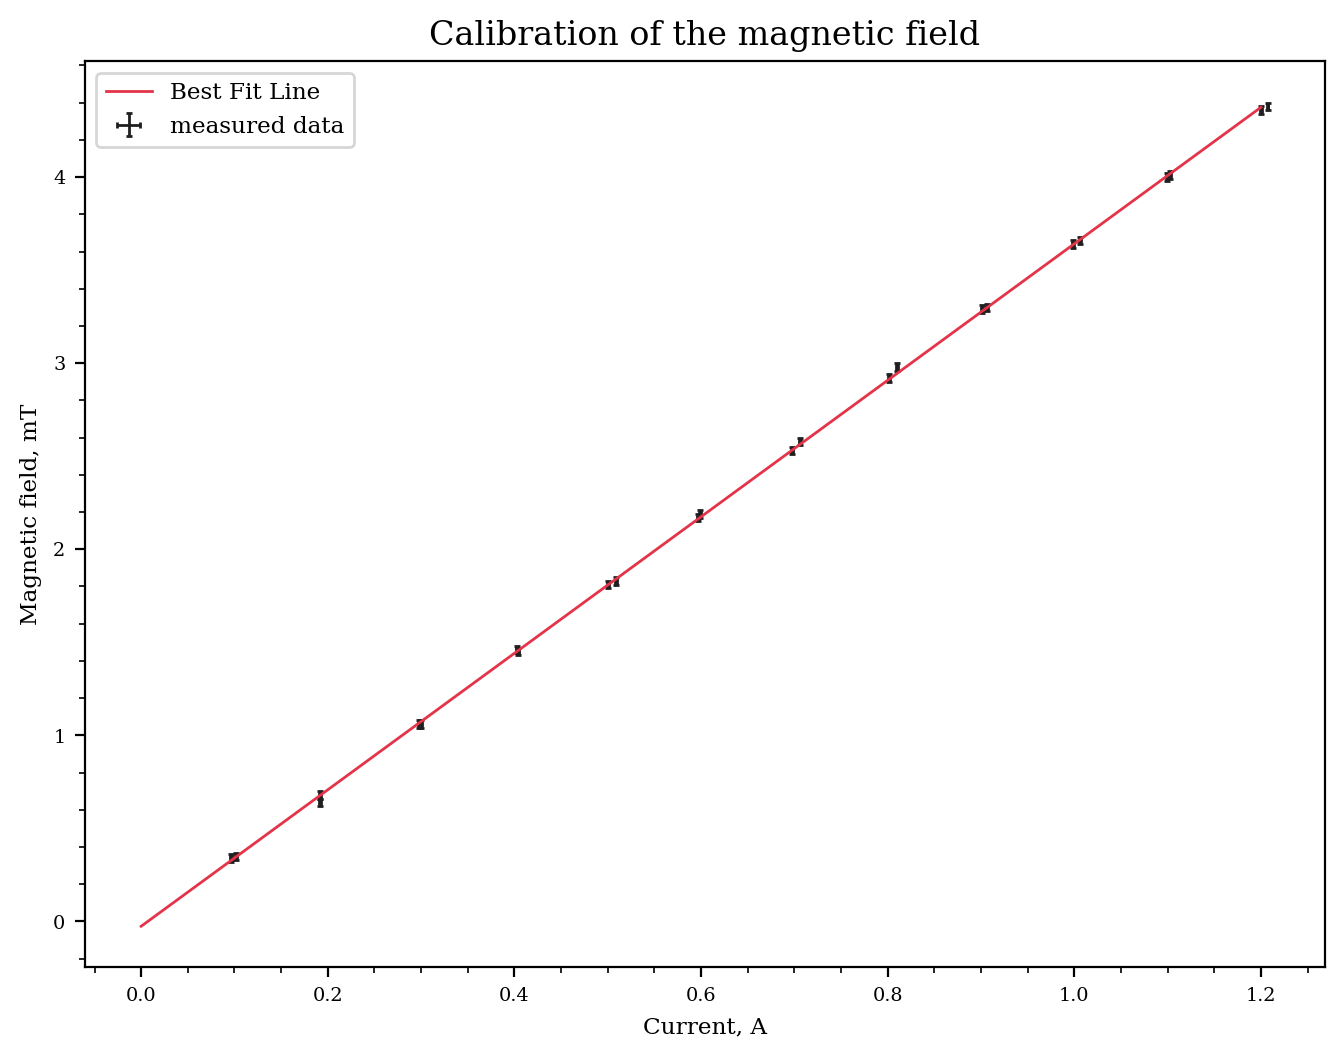

In [17]:
#define the equation for a linear fit
def linear_function(x,m,c):
    return m*x+c

p, p_cov = optimize.curve_fit(linear_function, current, B_0 , sigma = errorB*np.ones_like(B_0), absolute_sigma=True)
    
    #parameters of the fit function
fitted_m = p[0]
fitted_c = p[1]

#error in the parameters are the square root of the diagonal of the covariant matrix
err_fitted_m = np.sqrt(p_cov[0,0])
err_fitted_c = np.sqrt(p_cov[1,1])

#printing the equation
print('the best fit line would be: y = {0:.3f}x + {1:.3f}'.format(fitted_m,fitted_c))
print('where the error on the slope is {0:.2g},'.format(err_fitted_m))
print('and where the error on the intercept is {0:.1g}.'.format(err_fitted_c))


#plotting
print('We therefore get the following graph:')

    #independant variable, to complete
x = np.linspace(0,1.2)

    #original values
plt.figure(figsize=[8,6])
plt.errorbar(current, B_0, xerr = errorI*np.ones_like(current), yerr=errorB*np.ones_like(B_0), fmt='none', label = 'measured data')

    #best fit
plt.plot(x,linear_function(x, fitted_m, fitted_c), label= 'Best Fit Line')
plt.legend()
plt.xlabel('Current, A')
plt.ylabel('Magnetic field, mT')
plt.title('Calibration of the magnetic field')
plt.savefig('ESR_current_calibration.pdf')
plt.show()

This is a very good fit as there are no outlying data points. Rewriting the calibration equation for clarity, we have

$$B_0 = (3.667 \pm 0.012 \, \mathrm{mT/A}) I - (0.026 \pm 0.009 \, \mathrm{mT})$$

However, although the fit seems very good, the value for the slope is not consistent with what we should have found. Indeed, as $n = 320$, the slope should be equal to $4.23$, which is quite far from our value ($-13 \%$ difference). Some of this could come from the existence of the offset, but not much, as it is very small. Some small error may have been introduced by assuming the relative permeability of air is 1 and that the radius is exactly 6.8 cm. Another possibility is that the Helmholtz coils were not placed exactly 6.8 cm appart, which would have modified the initial relation. The most likely cause, however, is the placement of the Hall probe. Firstly, the magnetic field inside the Helmholtz coil is not completely uniform, and changes depending on the distance to the coil. This may have contributed a small amount, but for it to have contributed fully, we would need the measured magnetic field to be $1.15$ times that of the value at the centre, but I can guarantee you that it wasn't that close to the coils. See figure ??? taken from https://en.wikipedia.org/wiki/Helmholtz_coil#/media/File:Helmholtz_coil,_B_magnitude_cross_section.svg .

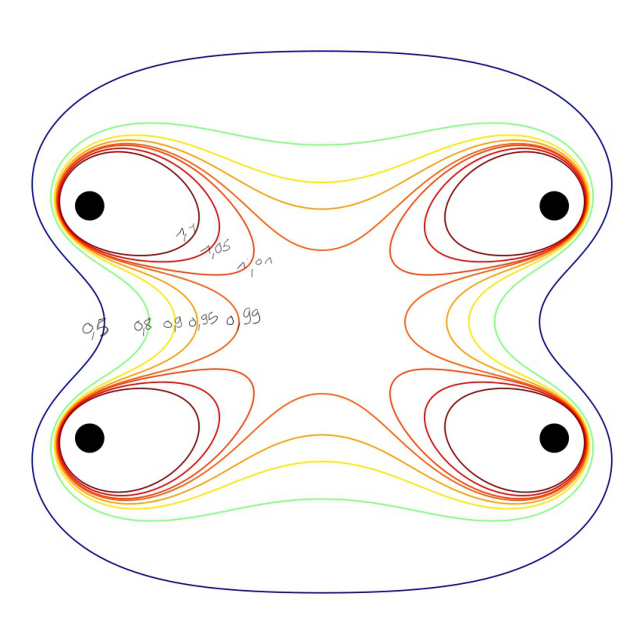

In [23]:
coils = plt.imread('Helmholtz_coil.png')
plt.figure(figsize=(6,4))  # Sets the size of the displayed image
plt.imshow(coils)
plt.axis('off')
plt.show()

Here, I annotated the image to show the value of the contour lines, in units of $B_0$. Further, as I tried placing the probe as close as possible to where the sample and RF coil would be, all this shouldn't matter too much

The final possible explanation I can find is that the probe's orientation means 

### Determining the g-factor of DPPH

WHAT DO YOU WANT??? Explain with photo of oscilloscope.

We needed tabulated data of $I$ and frequency $\nu$ for the small, medium and large coils. EXPLAIN WHY THEY HAVE DIFFERENT FREQUENCY RANGES

**example photos of resonnance signals**

Followed what was in the lab script. Changing DC current so that peaks (ESR signal) coincide with sine wave (B signal) when it crosses 0. WHAT DOES IT MEAN PHYSICALLY?

When I reached 30MHz, I changed large coil to medium one.

Hard to make things symmetric, but still beyond the precision so not too serious (rephrase). See error estimates later on. Partly because 'I=' toggle not very sensitive, hard to adjust finely.

I sometimes had to wait a bit for the frequency to settle down.

I couldn't reach 75 MHz for medium coil (would begin decreasing before I could), so had to do this measurement with smallest coil.

Had to increase AC current to widen peak for 75 MHz. Peak doesn't look sharp at all PHOTO. did as best I could. But gets sharper as I increase the current. Perhaps has to do with the fact it's at the edge on the measuring range. 

Also had trouble for 95MHz and 100MHz. The current for the two is quite close, which might be because I fiddled, or because my measurements were bad because I wasn't quite sure when the peak was symmetric.

Couldn't get 130MHz because it keeps bouncing back

Measurements not very good e.g. for 95 and 100 MHz, so I'm going to repeat them to reduce random error because of how hard it was to get the peak to be symmetrical.

I estimate the error on current to be about 0.005A, because this is how much the current changed when I tried adjusting the current to get a symmetric peak
I estimate the error on frequency to be 0.1MHz because this is how precise the oscillator is.


## Results

# Determination of the half-width $\delta \mathrm{B_0}$ for DPPH

## Aims

## Experimental Methods

### Calibration (if different)

### Calculating half-width

Same set up as part 1. I chose the medium coil to use for 50MHz resonnance peak.

I adjusted everything as described in lab script, choosing the XY mode on the oscillator.

Measure $I_{mod}(\mathrm{RMS})=0.285 \mathrm{A}$ once I extended the signal to 10cm in the X-axis.

Adjusted background to be on a line (1/4 of the screen down) for 500mVx500mV graph so that peak could be easily readable, as seen on photo ADD NAME!

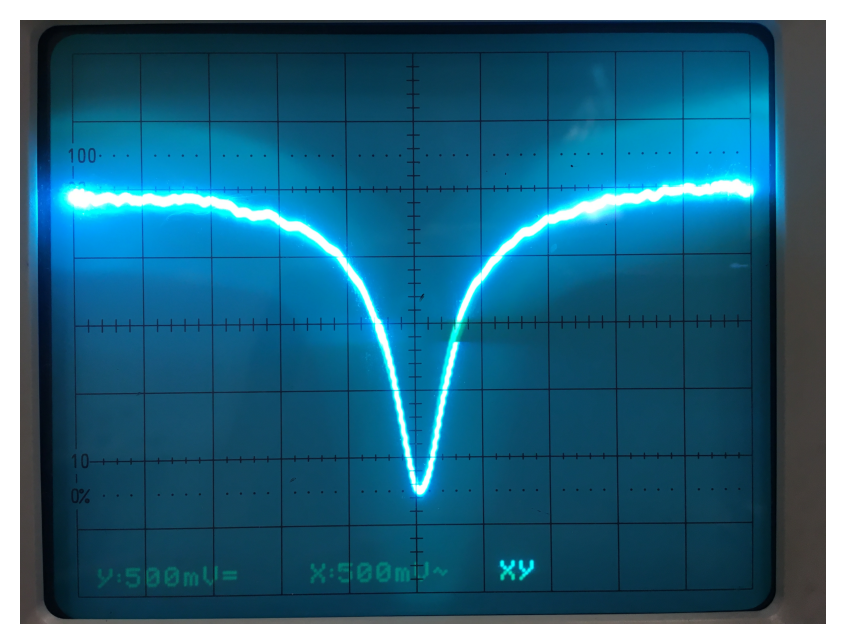

In [13]:
firstphoto = plt.imread('500x500mV.png')
plt.figure(figsize=(6,4))  # Sets the size of the displayed image
plt.imshow(firstphoto)
plt.axis('off')
plt.show()

Widened the scale in the x-axis (decreased to 200mV/cm) to better read the half width during the analysis, as seen in picture: (ADD TITLE+NUMBER)

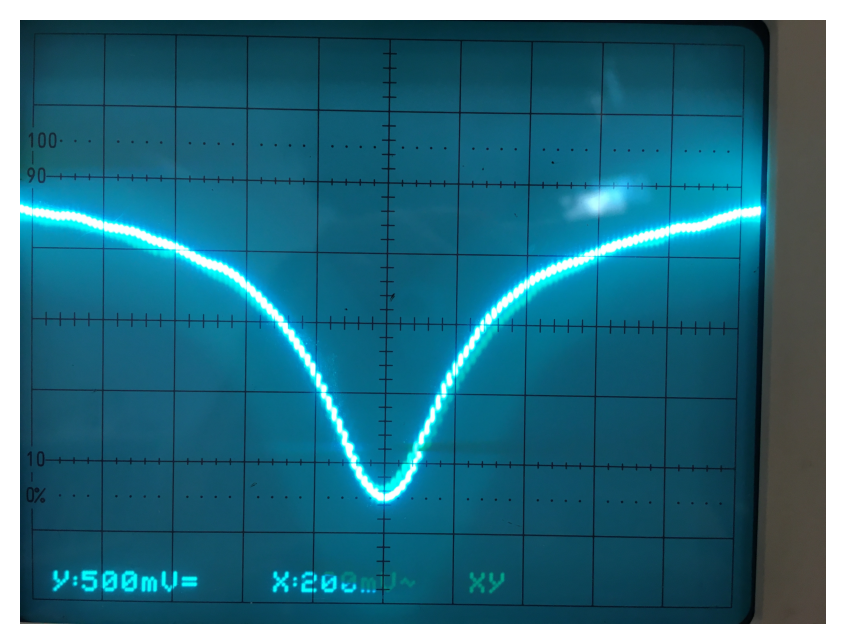

In [14]:
secondphoto = plt.imread('200x500mV.png')
plt.figure(figsize=(6,4))  # Sets the size of the displayed image
plt.imshow(secondphoto)
plt.axis('off')
plt.show()

## Results

# Discussion and Conclusion